In [1]:
import numpy as np
import torch
from torch import nn
import seaborn as sns
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

/home/mmazeem/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Train Model

### Dataloader

In [2]:
class SmokingDataset(Dataset):
    def __init__(self, dir):
        self.dir = dir
    
    def __len__(self):
        return len(os.listdir(self.dir))
    
    def __getitem__(self, key):
        if isinstance(key, slice):
            stop, start, step = key.indices(len(self))

            length = len(range(stop, start, step))
            X = torch.zeros([length, 300])
            y = torch.zeros([length, 1])

            for j,i in enumerate(range(stop, start, step)):
                xi, yi = self[i]
                X[j] = xi
                y[j] = yi

            return (X, y)

        elif isinstance(key, int):
            X, y = torch.load(os.path.join(self.dir, f'{key}.pt'))
            return (X.flatten(), y)

In [3]:
train_dataset = SmokingDataset('pipeline/4_all/train/')
test_dataset = SmokingDataset('pipeline/4_all/test/')

train_length = len(train_dataset)
test_length = len(test_dataset)

In [4]:
# Get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [5]:
# Define Model
n_hl = 10

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(300, n_hl),
            nn.ReLU(),
            nn.Linear(n_hl, 1)
        )
    
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits  

model = MLP().to(device)
    
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [44]:
# Define training parameters and preapre dataloaders from saved datasets

epochs = 10
batch_size = 64

losses = []
test_losses = []

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=907)    # batches for memory (907 is magic number that leads to close to whole ratio between n_train_batches and n_test_batches)

n_train_batches = len(train_dataloader)
n_test_batches = len(test_dataloader)

os.system('mkdir -p model results/training');

In [45]:
# Train
for epoch in range(epochs):

    print(f'Epoch {epoch} - Training')
    model.train()
    losses.append(0)

    for X_train, y_train in tqdm(train_dataloader):

        X_train = X_train.to(device)
        y_train = y_train.to(device)

        # Forward Pass
        logits = model(X_train)
        loss = criterion(logits, y_train)

        # Backward Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses[-1] += loss.item()

    losses[-1] /= n_train_batches
    print(f'\tloss: {losses[-1]}')


    ## Test
    print(f'Epoch {epoch} - Testing')
    model.eval()

    preds = []
    n_correct = 0
    test_losses.append(0)

    for X_test, y_test in tqdm(test_dataloader):
        X_test = X_test.to(device)
        y_test = y_test.to(device)

        logits = model(X_test)
        pred = torch.round(nn.Sigmoid()(logits))

        n_correct += sum(y_test == pred)
        preds += pred.flatten().tolist()
        loss = criterion(logits, y_test)
        test_losses[-1] += loss.item()

    test_losses[-1] /= n_test_batches
    accuracy = (n_correct / test_length).item()
    print(f'\tTest Accuracy: {100*accuracy:.4}%')
    print(f'\tTest Loss: {test_losses[-1]}')

    os.system('mkdir model')
    torch.save(model.state_dict(), f'model/model-epoch-{epoch}.pt')

torch.save(losses, f'results/training/train_losses.pt')
torch.save(test_losses, f'results/training/test_losses.pt')

Epoch 0 - Training


100%|██████████| 13393/13393 [02:43<00:00, 81.98it/s]


	loss: 0.09262478279276963
Epoch 0 - Testing


100%|██████████| 405/405 [01:08<00:00,  5.92it/s]
mkdir: cannot create directory ‘model’: File exists


	Test Accuracy: 96.5%
	Test Loss: 0.094824073932789
Epoch 1 - Training


100%|██████████| 13393/13393 [02:48<00:00, 79.29it/s]


	loss: 0.0920874889533087
Epoch 1 - Testing


100%|██████████| 405/405 [01:05<00:00,  6.18it/s]
mkdir: cannot create directory ‘model’: File exists


	Test Accuracy: 96.5%
	Test Loss: 0.09457448334605606
Epoch 2 - Training


100%|██████████| 13393/13393 [03:09<00:00, 70.75it/s]


	loss: 0.09166642533626913
Epoch 2 - Testing


100%|██████████| 405/405 [01:17<00:00,  5.20it/s]
mkdir: cannot create directory ‘model’: File exists


	Test Accuracy: 96.52%
	Test Loss: 0.09464886653938412
Epoch 3 - Training


100%|██████████| 13393/13393 [02:39<00:00, 84.15it/s]


	loss: 0.09129273860083854
Epoch 3 - Testing


100%|██████████| 405/405 [00:59<00:00,  6.86it/s]
mkdir: cannot create directory ‘model’: File exists


	Test Accuracy: 96.51%
	Test Loss: 0.09478478713168038
Epoch 4 - Training


100%|██████████| 13393/13393 [02:45<00:00, 80.68it/s]


	loss: 0.09067846071608557
Epoch 4 - Testing


100%|██████████| 405/405 [01:09<00:00,  5.85it/s]
mkdir: cannot create directory ‘model’: File exists


	Test Accuracy: 96.64%
	Test Loss: 0.093352704807932
Epoch 5 - Training


100%|██████████| 13393/13393 [02:56<00:00, 76.09it/s]


	loss: 0.09010906938196701
Epoch 5 - Testing


100%|██████████| 405/405 [01:00<00:00,  6.68it/s]
mkdir: cannot create directory ‘model’: File exists


	Test Accuracy: 96.7%
	Test Loss: 0.09241447726517547
Epoch 6 - Training


100%|██████████| 13393/13393 [02:27<00:00, 91.03it/s]


	loss: 0.089684315851014
Epoch 6 - Testing


100%|██████████| 405/405 [00:58<00:00,  6.92it/s]
mkdir: cannot create directory ‘model’: File exists


	Test Accuracy: 96.69%
	Test Loss: 0.0921757073774014
Epoch 7 - Training


100%|██████████| 13393/13393 [02:27<00:00, 91.03it/s]


	loss: 0.0891781454405333
Epoch 7 - Testing


100%|██████████| 405/405 [00:58<00:00,  6.87it/s]
mkdir: cannot create directory ‘model’: File exists


	Test Accuracy: 96.7%
	Test Loss: 0.09162142638255048
Epoch 8 - Training


100%|██████████| 13393/13393 [02:46<00:00, 80.68it/s]


	loss: 0.08880288790872355
Epoch 8 - Testing


100%|██████████| 405/405 [01:02<00:00,  6.47it/s]
mkdir: cannot create directory ‘model’: File exists


	Test Accuracy: 96.74%
	Test Loss: 0.09081562650792392
Epoch 9 - Training


100%|██████████| 13393/13393 [02:39<00:00, 83.91it/s]


	loss: 0.08851578689342268
Epoch 9 - Testing


100%|██████████| 405/405 [00:59<00:00,  6.83it/s]

	Test Accuracy: 96.74%
	Test Loss: 0.09046494902835953



mkdir: cannot create directory ‘model’: File exists


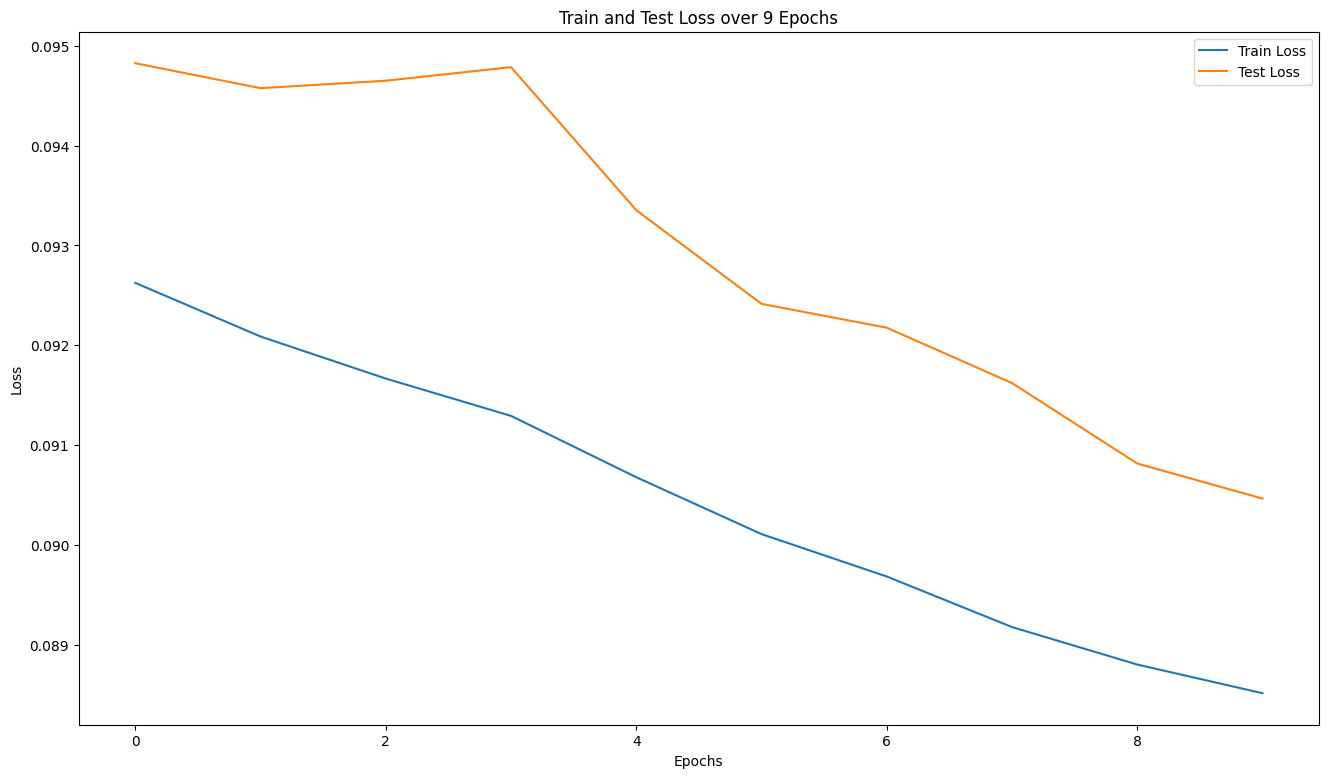

In [49]:
# Plot loss curve at specified resolution (save losses and plot)
os.system('mkdir -p results/figures')

epoch_toplot = 10
losses_toplot = torch.load(f'results/training/train_losses.pt')[:epoch_toplot]
test_losses_toplot = torch.load(f'results/training/test_losses.pt')[:epoch_toplot]

fig, ax = plt.subplots(1)
ax.plot(torch.tensor(losses_toplot), label='Train Loss')
ax.plot(torch.tensor(test_losses_toplot), label='Test Loss')
ax.set_ylabel("Loss")
ax.set_xlabel('Epochs')
ax.legend()
ax.set_title(f'Train and Test Loss over {epoch} Epochs')
fig.set_size_inches(16, 9)
plt.savefig(f'results/training/train_test_loss-{epoch}-epochs.jpg', dpi=400)